# MLP regressor

Here I train a MLP regressor with each of the different granularity data sets 

The target variable is "Unvalidated"

I show performance based on 
a) "R squared" - the amount of variation in y that is explained by X - with X being the MLP regressor
b) "RMSE"  - what is the mean squared error of a prediction 

Given the limited compute power I have access to, the depth of the MLP regressor is quite limited. Perhaps it woudl perform better with additional depth + nodes + hyperparameter tuning

In [1]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
import glob
import os 
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def MLP_Regression(df):
    X = df.drop(columns = ["Unvalidated_mean"])
    y = df["Unvalidated_mean"]
    sample_weights = X["n_rows"]
    X.drop(columns=["n_rows"], inplace = True)
    

    X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, y, sample_weights, test_size = 0.2, random_state = 42)
    
    # Scale only numeric features
    numeric_cols = ["density", "Visiting_score", "Rel_Visiting_score", "Validation_Count_mean"]
    scaler = StandardScaler()
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()
    X_train_scaled[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
    X_test_scaled[numeric_cols] = scaler.transform(X_test[numeric_cols])
    
    mlp_reg = MLPRegressor(
        hidden_layer_sizes=(128, 128, 128, 128, 64, 32),
        activation="relu",
        solver="adam",
        alpha=1e-4,
        max_iter=1000,
        early_stopping=True,
        validation_fraction=0.1,
        random_state=42
            )

    # weighting based on support

    mlp_reg.fit(X_train, y_train, sample_weight = w_train)
    
    y_pred = mlp_reg.predict(X_test)

    RMSE = np.sqrt(mean_squared_error((y_test), y_pred))
    R_squared = r2_score(y_test, y_pred)

    return RMSE, R_squared

In [3]:

Performance = []

files = glob.glob("c:/users/henry chapman/Documents/Coding/Data_science/Project_final/Output/2_Granularity_tuning/Pipe2/*.csv")
for file in files:
    Name = os.path.basename(file).split(".")[0]
    print(Name)
    df = pd.read_csv(file)
    df.drop(columns = ["Unnamed: 0"], inplace = True)
    
    # Running MLP regressor 
    RMSE, R_squared = MLP_Regression(df)

    # save in a df 
    Performance.append([Name, RMSE, R_squared])
    

Combo_120min_Collapseall_Final
Combo_120min_Dayofweek_Final
Combo_120min_Weekendsplit_Final
Combo_180min_Collapseall_Final
Combo_180min_Dayofweek_Final
Combo_180min_Weekendsplit_Final
Combo_30min_Collapseall_Final
Combo_30min_Dayofweek_Final
Combo_30min_Weekendsplit_Final
Combo_360min_Collapseall_Final
Combo_360min_Dayofweek_Final
Combo_360min_Weekendsplit_Final
Combo_60min_Collapseall_Final
Combo_60min_Dayofweek_Final
Combo_60min_Weekendsplit_Final
Combo_720min_Collapseall_Final
Combo_720min_Dayofweek_Final
Combo_720min_Weekendsplit_Final


In [22]:
#Convert to DataFrame and export for eqasy manipulation in future
Performance = pd.DataFrame(Performance, columns=["Combo", "RMSE", "R_squared"])

Performance.to_csv("c:/users/henry chapman/Documents/Coding/Data_science/Project_final/Output/5_Predicting_future_date/Pipe1/MLP_performace.csv", index = False)

In [26]:
data.head()

,Combo,RMSE,R_squared
0,Combo_120min_Collapseall_Final,1.293457,0.103837
1,Combo_120min_Dayofweek_Final,1.292116,0.105695
2,Combo_120min_Weekendsplit_Final,1.289096,0.109871
3,Combo_180min_Collapseall_Final,1.334466,0.103144
4,Combo_180min_Dayofweek_Final,1.335685,0.101504


In [57]:
data = pd.read_csv("c:/users/henry chapman/Documents/Coding/Data_science/Project_final/Output/5_Predicting_future_date/Pipe1/MLP_performace.csv")
data.head()

data["Combo"] = data["Combo"].apply(lambda x: "_".join(x.split("_")[1:3]))

data.head()

data["Time_gran"] = data["Combo"].apply(lambda x : x.split("_")[0])
data["Day_gran"] = data["Combo"].apply(lambda x : x.split("_")[1])

data.head()

,Combo,RMSE,R_squared,Time_gran,Day_gran
0,120min_Collapseall,1.293457,0.103837,120min,Collapseall
1,120min_Dayofweek,1.292116,0.105695,120min,Dayofweek
2,120min_Weekendsplit,1.289096,0.109871,120min,Weekendsplit
3,180min_Collapseall,1.334466,0.103144,180min,Collapseall
4,180min_Dayofweek,1.335685,0.101504,180min,Dayofweek


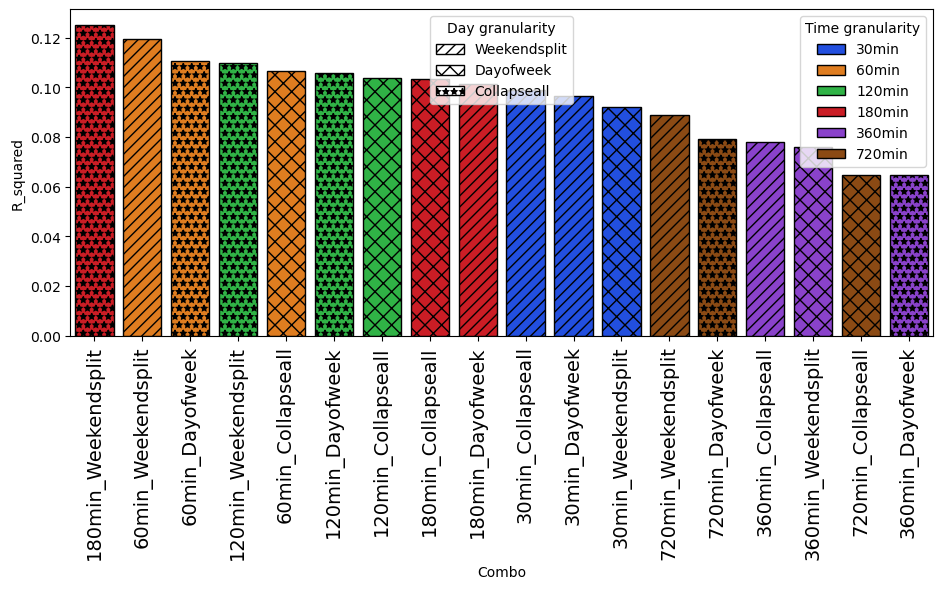

In [103]:
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

hue_order = ["30min", "60min", "120min", "180min", "360min", "720min"]
# --- Plot ---
plt.figure(figsize=(10, 4))
ax = sns.barplot(
    data=data,
    x="Combo",
    y="R_squared",
    hue="Time_gran",
    palette="bright",
    edgecolor="black",
    linewidth=1,
    hue_order = hue_order
)

# --- Apply hatches based on Day_gran ---
hatch_map = {
    category: hatch
    for category, hatch in zip(data["Day_gran"].unique(),
                               ["///", "xx", "**", ".."])
}

# Assign hatch row-by-row
for bar, (_, row) in zip(ax.patches, data.iterrows()):
    bar.set_hatch(hatch_map[row["Day_gran"]])

# --- (1) HUE LEGEND: seaborn creates it automatically ---
hue_legend = ax.legend(title="Time granularity", loc="upper right")

# --- (2) HATCH LEGEND: created manually ---
hatch_handles = [
    Patch(facecolor="white",
          edgecolor="black",
          hatch=hatch,
          label=str(cat))
    for cat, hatch in hatch_map.items()
]

hatch_legend = plt.legend(
    handles=hatch_handles,
    title="Day granularity",
    loc="upper center"
)

# Keep both legends visible
ax.add_artist(hue_legend)
plt.tight_layout()
plt.xticks(rotation = 90, size = "14")

plt.savefig(
    "c:/users/henry chapman/Documents/Coding/Data_science/Project_final/Output/3_ML_performance/Pipe1/MLP_regression_Rsquared.svg",
    format='svg',                 
    bbox_inches='tight'           
)
plt.show()
